# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho



**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

Código Python completo e bem comentado para análise de séries temporais do dataset `data.csv`.

Este script cobre:
 - Análise exploratória (visualizações e estatísticas)
 - Métricas de avaliação (MAE, RMSE, MAPE)
 - Transformações (log, Box-Cox, diferenciação)
 - Testes de estacionariedade (ADF, KPSS)
 - Decomposição (trend/seasonal/residual)
 - Baselines (Naive, Seasonal Naive, Rolling mean)
 - Regressão linear múltipla com variáveis de tempo (tendência, sen/cos sazonais, dummies)
 - Modelos clássicos (ARIMA/SARIMA via pmdarima e statsmodels)
 - Diagnóstico de resíduos (ACF/PACF, Ljung-Box, histogramas)
 - Comparação de modelos e exportação de resultados

# Imports

In [16]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


!pip install statsmodels pmdarima scipy
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

#

# Funções Utilitárias

## RMSE

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


## MAPE

In [18]:
def mape(y_true, y_pred):
    # evitar divisão por zero — retorna np.nan onde y_true==0
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## Split data

In [19]:
def train_test_split_ts(df, test_size=0.2):
    # split temporal: últimos test_size (proporção) usados como teste
    n = len(df)
    split = int(np.floor(n * (1 - test_size)))
    return df.iloc[:split].copy(), df.iloc[split:].copy()

In [20]:
# Funções utilitárias

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred):
    # evitar divisão por zero — retorna np.nan onde y_true==0
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def train_test_split_ts(df, test_size=0.2):
    # split temporal: últimos test_size (proporção) usados como teste
    n = len(df)
    split = int(np.floor(n * (1 - test_size)))
    return df.iloc[:split].copy(), df.iloc[split:].copy()


# Carregamento dos dados

Os dados foram carregados na varável `df` como um `pandas_datframe` e a variável `series`foi definida como uma Series pandas da variável volume

In [21]:
# Carregar dados
DATA_PATH = Path('data.csv')
df = pd.read_csv(DATA_PATH)

# indexando pelas datas
df['week_dt'] = pd.to_datetime(df['week'])
df.set_index('week_dt', inplace=True)
df.index.name = 'week'

# manter apenas coluna volume
series = df['volume'].astype(float)
series.name = 'volume'

print(f"\nTamanho da série: {len(series)} observações")
print(series.describe())



Tamanho da série: 150 observações
count    150.000000
mean       4.119200
std        4.053351
min        0.140000
25%        0.652500
50%        3.000000
75%        6.455000
max       16.590000
Name: volume, dtype: float64


## Discussão sobre métricas e métodos de avaliação

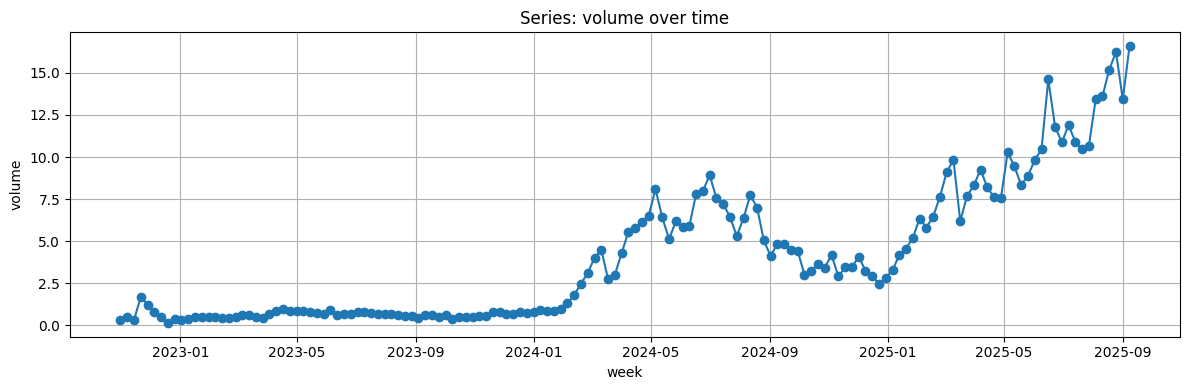

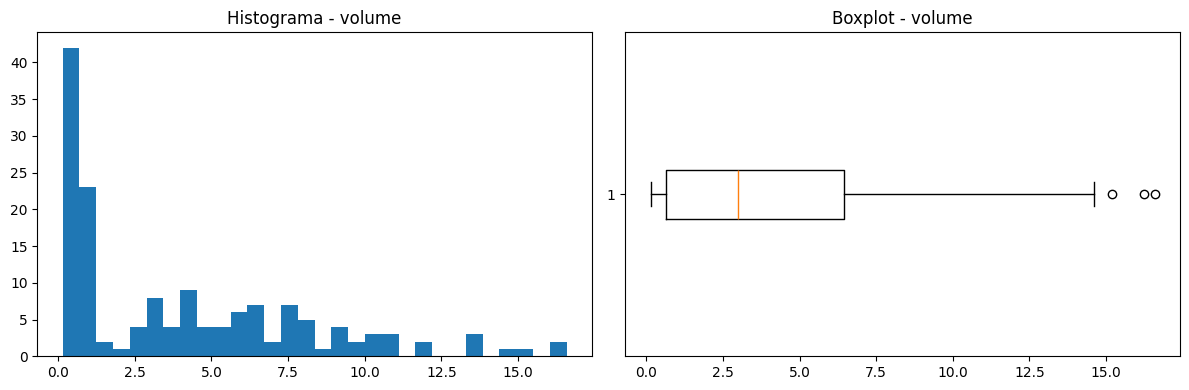

Valores missing em 'volume': 0


In [22]:
# Análise exploratória

plt.figure(figsize=(12,4))
plt.plot(series, marker='o', linestyle='-')
plt.title('Series: volume over time')
plt.ylabel('volume')
plt.xlabel('week')
plt.grid(True)
plt.tight_layout()
plt.show()

# histograma e boxplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(series.dropna(), bins=30)
plt.title('Histograma - volume')
plt.subplot(1,2,2)
plt.boxplot(series.dropna(), vert=False)
plt.title('Boxplot - volume')
plt.tight_layout()
plt.show()

# verificar ausentes
n_missing = series.isna().sum()
print(f"Valores missing em 'volume': {n_missing}")


In [23]:
print("Intervalo dos dados:", series.min(),",", series.max())
print(len(series[series < 1]), "valores menores que 1", )

Intervalo dos dados: 0.14 , 16.59
64 valores menores que 1


## Testes de estacionariedade


In [24]:
# Testes de estacionariedade: ADF e KPSS

from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(y):
    print('\n--- Teste de estacionariedade ---')
    y_clean = y.dropna()
    adf_res = adfuller(y_clean, autolag='AIC')
    print(f"ADF: stat={adf_res[0]:.4f}, p-val={adf_res[1]:.4f}, n_lags={adf_res[2]}")
    print('ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária')

    kpss_res = kpss(y_clean, regression='c', nlags='auto')
    print(f"KPSS: stat={kpss_res[0]:.4f}, p-val={kpss_res[1]:.4f}")
    print('KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária')

test_stationarity(series)


--- Teste de estacionariedade ---
ADF: stat=1.0022, p-val=0.9943, n_lags=2
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=1.4012, p-val=0.0100
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária


### Teste de Dickey-Fuller Aumentado (ADF)

O teste ADF tenta determinar se uma série temporal possui uma **raiz unitária**. Uma raiz unitária é uma característica de séries não estacionárias, indicando que os choques (mudanças inesperadas) na série têm efeitos permanentes, fazendo com que ela "ande aleatoriamente" e não retorne a uma média constante.

Pense em uma série que segue um "passeio aleatório" (random walk): `Y(t) = Y(t-1) + e(t)`, onde `e(t)` é ruído branco. A melhor previsão para `Y(t)` é `Y(t-1)`. A diferença `Y(t) - Y(t-1)` é estacionária (apenas o ruído). O teste ADF verifica se essa relação de "dependência da observação anterior" existe de forma que a série não seja estacionária.

O teste ADF é baseado na seguinte regressão:

`ΔY(t) = α + β*Y(t-1) + δ₁*ΔY(t-1) + ... + δₚ*ΔY(t-p) + ε(t)`

Onde:
- `ΔY(t)` é a primeira diferença da série no tempo `t` (`Y(t) - Y(t-1)`).
- `Y(t-1)` é o valor da série no tempo `t-1`.
- `α` é o intercepto (permite testar estacionariedade em torno de uma média não zero).
- `β` é o coeficiente de interesse principal.
- `ΔY(t-k)` são termos de diferenças defasadas para capturar estruturas de autocorrelação (por isso "Aumentado").
- `ε(t)` é o termo de erro (espera-se que seja ruído branco).

A **Hipótese Nula (H0)** é que **β = 0**. Se β = 0, a equação se assemelha a um passeio aleatório com ou sem tendência, indicando **não estacionariedade**.
A **Hipótese Alternativa (H1)** é que **β < 0**. Se β é negativo, a série tende a retornar à sua média ou tendência, indicando **estacionariedade**.

O teste calcula um estatístico (o estatístico ADF) e compara com valores críticos. Um valor p baixo indica que é improvável observar o estatístico calculado sob a H0, levando à sua rejeição e à conclusão de estacionariedade.



### Teste KPSS

Em contraste com o ADF, o teste KPSS verifica se a série é estacionária em torno de uma **tendência determinística** (ou média constante). Ele decompõe a série em três partes: tendência determinística, passeio aleatório e erro estacionário. O teste verifica se a componente de passeio aleatório tem variância zero.

Pense em uma série que é a soma de uma tendência linear e ruído branco: `Y(t) = a + b*t + e(t)`. Esta série tem uma tendência determinística. O teste KPSS verifica se há uma componente estocástica (como um passeio aleatório) que a torna não estacionária para além dessa tendência ou média.

O teste KPSS é baseado nos resíduos de uma regressão da série `Y(t)` em relação a uma constante (para testar estacionariedade em torno da média) ou a uma constante e uma tendência (para testar estacionariedade em torno de uma tendência linear).

1.  Regressão: `Y(t) = μ + δ*t + u(t)` (onde δ=0 para o caso de apenas média). Os resíduos são `u(t)`.
2.  Calcula-se a soma cumulativa dos resíduos: `S(t) = Σ u(i)` para i=1 até t.
3.  O estatístico KPSS é construído a partir da soma dos quadrados de `S(t)` normalizada pela variância de longo prazo dos resíduos.

A **Hipótese Nula (H0)** é que a série **é estacionária** (a variância da componente de passeio aleatório é zero).
A **Hipótese Alternativa (H1)** é que a série **não é estacionária**.

Um estatístico KPSS grande (e, portanto, um valor p baixo) sugere que a soma cumulativa dos resíduos se afasta significativamente de zero, indicando que há uma componente de passeio aleatório presente e que a série não é estacionária.



In [25]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

# Função de teste
def test_stationarity(y):
    print('\n--- Teste de estacionariedade ---')
    y_clean = y.dropna()

    adf_res = adfuller(y_clean, autolag='AIC')
    print(f"ADF: stat={adf_res[0]:.4f}, p-val={adf_res[1]:.4f}, n_lags={adf_res[2]}")
    print('ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária')

    kpss_res = kpss(y_clean, regression='c', nlags='auto')
    print(f"KPSS: stat={kpss_res[0]:.4f}, p-val={kpss_res[1]:.4f}")
    print('KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária')

# Evita warnings chatos
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 1ª diferença
series_diff = series.diff().dropna()

print("=== Série original ===")
test_stationarity(series)

print("\n=== Série diferenciada (1ª diferença) ===")
test_stationarity(series_diff)


=== Série original ===

--- Teste de estacionariedade ---
ADF: stat=1.0022, p-val=0.9943, n_lags=2
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=1.4012, p-val=0.0100
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária

=== Série diferenciada (1ª diferença) ===

--- Teste de estacionariedade ---
ADF: stat=-10.8391, p-val=0.0000, n_lags=1
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=0.3090, p-val=0.1000
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária


### A Série Diferenciada e a Estacionariedade

Como vimos na análise inicial, a série original de `volume` mostrou sinais de **não estacionariedade** nos testes ADF e KPSS. Isso geralmente indica a presença de uma tendência ou outras estruturas que fazem com que as propriedades estatísticas da série mudem ao longo do tempo.

Para lidar com isso e preparar a série para modelos que assumem estacionariedade (como ARIMA), aplicamos a **diferenciação**.

A **diferenciação de primeira ordem** calcula a diferença entre cada observação e a observação imediatamente anterior:

`ΔY(t) = Y(t) - Y(t-1)`

Onde:
- `Y(t)` é o valor da série no tempo `t`.
- `Y(t-1)` é o valor da série no tempo `t-1`.
- `ΔY(t)` é o valor da série diferenciada no tempo `t`.

Visualmente, se a série original tem uma tendência linear crescente, a série diferenciada tenderá a flutuar em torno de zero. Se a série tem sazonalidade, a diferenciação sazonal (`Y(t) - Y(t-m)`, onde `m` é o período sazonal) pode remover esse padrão repetitivo.

No código, a primeira diferença foi calculada com `series.diff().dropna()`, resultando na série `series_diff`.

Após aplicar a primeira diferença, executamos novamente os testes ADF e KPSS na série `series_diff`. Os resultados foram:

- **Teste ADF:** `p-val = 0.0000`
    - Como o p-valor (0.0000) é **menor que 0.05**, nós **rejeitamos a Hipótese Nula (H0)** de raiz unitária.
    - **Conclusão do ADF:** A série diferenciada **é estacionária**.

- **Teste KPSS:** `p-val = 0.1000`
    - Como o p-valor (0.1000) é **maior que 0.05**, nós **não rejeitamos a Hipótese Nula (H0)** de estacionariedade.
    - **Conclusão do KPSS:** A série diferenciada **é estacionária**.

Ambos os testes, agora aplicados à série diferenciada, indicam consistentemente que a transformação foi bem-sucedida em remover a não estacionariedade. A série `series_diff` pode ser considerada estacionária e está adequada para modelos que requerem esta propriedade.


Transformações possíveis: log e Box-Cox (se scipy disponível)
Box-Cox aplicado. lambda=0.0496

Exemplo: plot da diferença (primeira ordem)


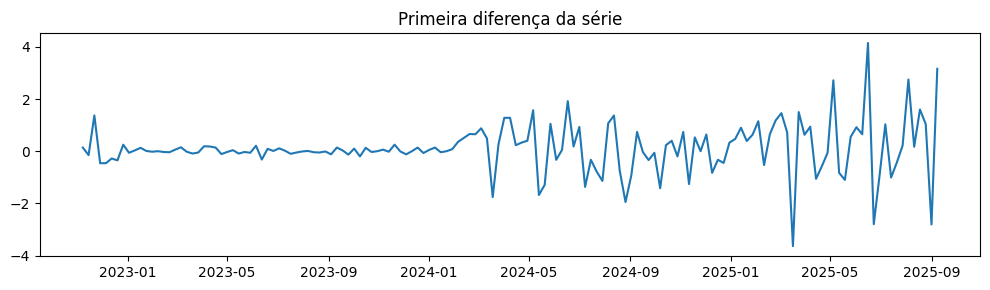

In [26]:
# Verifica se scipy está disponível
try:
    import scipy.stats as stats
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

# Criar cópia da série e verificar valores
series_pos = series.copy()

if (series_pos <= 0).any():
    print('\nAlguns valores não-positivos encontrados — Box-Cox e log não são aplicáveis diretamente.')
    series_log = None
    series_bc = None
else:
    print('\nTransformações possíveis: log e Box-Cox (se scipy disponível)')

    # aplicar log
    series_log = np.log(series_pos)

    # aplicar Box-Cox se scipy disponível
    if SCIPY_AVAILABLE:
        series_bc, bc_lambda = stats.boxcox(series_pos)
        print(f'Box-Cox aplicado. lambda={bc_lambda:.4f}')
    else:
        series_bc = None

# diferença de primeira ordem para estacionarizar tendência
series_diff = series.diff().dropna()

# plot da diferença
print('\nExemplo: plot da diferença (primeira ordem)')
plt.figure(figsize=(10,3))
plt.plot(series_diff)
plt.title('Primeira diferença da série')
plt.tight_layout()
plt.show()


## Decomposição Sazonal

A decomposição sazonal é como "desmontar" uma série temporal para entender as diferentes forças que a influenciam. Imagine que a série original é um bolo. A decomposição tenta separar o bolo em suas "camadas": a camada de **tendência** (o crescimento ou declínio geral), a camada de **sazonalidade** (os padrões que se repetem em certas épocas) e a camada de **resíduo** (o que sobra, que é imprevisível e aleatório).

O objetivo é isolar esses componentes para poder analisá-los individualmente, entender suas características e, se necessário, modelá-los separadamente ou usar essa informação para melhorar as previsões.

A decomposição sazonal é baseada em modelos que expressam a série temporal `Y(t)` como uma combinação de seus componentes. Os dois modelos mais comuns são:

1.  **Modelo Aditivo:**

    `Y(t) = T(t) + S(t) + R(t)`

    Onde:
    - `Y(t)` é o valor observado da série no tempo `t`.
    - `T(t)` é o componente de **tendência** no tempo `t`.
    - `S(t)` é o componente de **sazonalidade** no tempo `t`.
    - `R(t)` é o componente de **resíduo** (ou erro) no tempo `t`.

    Este modelo é apropriado quando a **amplitude** (tamanho) dos padrões sazonais é relativamente constante ao longo do tempo, independentemente do nível geral da série.

2.  **Modelo Multiplicativo:**

    `Y(t) = T(t) * S(t) * R(t)`

    Onde os termos têm o mesmo significado, mas a relação é multiplicativa.

    Este modelo é apropriado quando a **amplitude** dos padrões sazonais **aumenta ou diminui** à medida que o nível geral da série aumenta ou diminui.

**Como a decomposição é feita (Método Clássico, usado por `seasonal_decompose`):**

O método clássico geralmente segue estes passos:

1.  **Estimativa da Tendência (`T(t)`):** A tendência é geralmente estimada usando uma média móvel suavizada sobre um período igual ou ligeiramente maior que o período sazonal. Isso "suaviza" a sazonalidade e o ruído, deixando a tendência.
2.  **Remoção da Tendência:**
    - **Aditivo:** `Y(t) - T(t) = S(t) + R(t)`
    - **Multiplicativo:** `Y(t) / T(t) = S(t) * R(t)`
3.  **Estimativa da Sazonalidade (`S(t)`):** Para cada "ponto" dentro do ciclo sazonal (ex: cada semana do ano), calcula-se a média dos valores restantes após a remoção da tendência (`S(t) + R(t)` ou `S(t) * R(t)`) para aquele ponto específico ao longo de todos os ciclos disponíveis na série. Isso isola o padrão sazonal médio. As estimativas sazonais são então centralizadas (para somar zero no modelo aditivo ou ter média 1 no multiplicativo).
4.  **Estimativa do Resíduo (`R(t)`):** Após estimar a tendência e a sazonalidade, o resíduo é o que sobra:
    - **Aditivo:** `R(t) = Y(t) - T(t) - S(t)`
    - **Multiplicativo:** `R(t) = Y(t) / (T(t) * S(t))`

A visualização gerada pelo código mostra graficamente esses componentes, permitindo uma análise visual da estrutura da série.

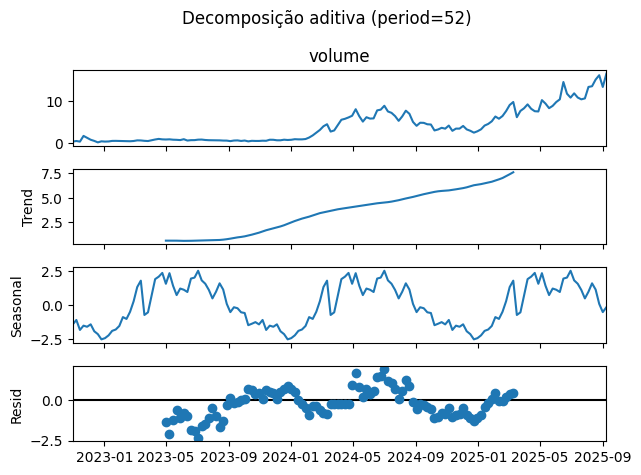

In [27]:
# Decomposição da série
# definiremos o periodo sazonal para dados semanais com 52 semanas
SEASONAL_PERIOD = 52
try:
    decomp = seasonal_decompose(series.dropna(), model='additive', period=SEASONAL_PERIOD)
    decomp.plot()
    plt.suptitle('Decomposição aditiva (period=52)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Erro na decomposição (provável que a série seja curta ou period inválido):', e)

In [28]:
# Split treino/teste
train, test = train_test_split_ts(series.to_frame(), test_size=0.2)
train_s = train['volume']
test_s = test['volume']
print(f"\nTreino: {len(train_s)} obs, Teste: {len(test_s)} obs")


Treino: 120 obs, Teste: 30 obs


# Modelos Baseline

<!-- Introdução -->
Modelos baseline são modelos de previsão simples e fáceis de implementar que servem como um ponto de partida e **referência** para avaliar o desempenho de modelos mais complexos.

Eles são importantes porque:

1.  **Fornecem um ponto de comparação:** Se um modelo sofisticado não consegue superar um baseline simples (como a previsão ingênua), isso sugere que o modelo complexo não está capturando bem os padrões da série, ou que a série é inerentemente difícil de prever.
2.  **São fáceis de entender e comunicar:** Seus resultados são intuitivos e fáceis de explicar para não especialistas.
3.  **Ajudam a identificar a dificuldade do problema:** Um baseline com erro muito alto indica que a série é volátil e difícil de prever com métodos simples.
4.  **Garantem que o modelo complexo agrega valor:** Ao comparar as métricas de erro (MAE, RMSE, MAPE) dos seus modelos de regressão ou SARIMA com as dos baselines, você pode quantificar o quanto seus modelos mais avançados realmente melhoram a previsão.

Nesta seção, implementaremos e avaliaremos alguns baselines comuns para ter essa referência inicial de desempenho.

In [32]:
# Pré-configuração para os modelos de baseline

# Lista para armazenar os resultados da avaliação de todos os baselines
base_eval = []

# Parâmetro para o Rolling Mean (número de períodos a serem considerados)
K = 4

### Método da Média (Mean Method)

Este método assume que a melhor previsão para o futuro é simplesmente a média dos valores históricos observados até o momento. A previsão para $h$ períodos à frente ($T+h$) é dada por:

$\hat{y}_{T+h|T} = \bar{y} = \frac{y_1 + ... + y_T}{T}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $\bar{y}$ é a média dos valores observados até o tempo $T$.
- $y_i$ é o valor observado no tempo $i$.
- $T$ é o número total de observações históricas.

Este método é eficaz quando a série temporal não apresenta uma tendência clara ou sazonalidade, e os valores futuros são esperados em torno da média histórica. É o baseline mais simples e serve para verificar se qualquer modelo mais complexo consegue superar a simples média histórica.

Mean Method Results:
  MAE: 7.9639
  RMSE: 8.4335
  MAPE: 74.2527%


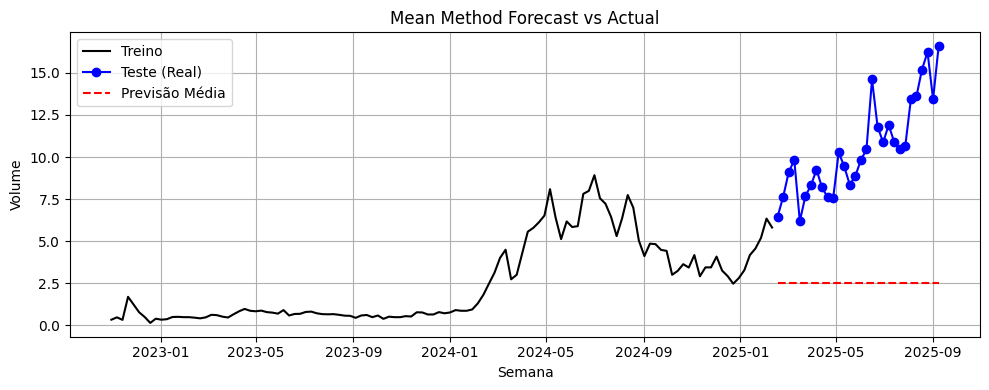

In [ ]:
# Mean Method: predição = média de todo o treino

# Calcular a previsão (a média do treino repetida para o tamanho do teste)
mean_pred = np.repeat(train_s.mean(), len(test_s))

# Avaliar o baseline da Média
mean_mae = mean_absolute_error(test_s, mean_pred)
mean_rmse = rmse(test_s, mean_pred)
mean_mape = mape(test_s, mean_pred)

# Armazenar os resultados
base_eval.append({'model': 'Mean', 'MAE': mean_mae, 'RMSE': mean_rmse, 'MAPE': mean_mape})

# Exibir os resultados para este baseline
print('Mean Method Results:')
print(f'  MAE: {mean_mae:.4f}')
print(f'  RMSE: {mean_rmse:.4f}')
print(f'  MAPE: {mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, mean_pred, label='Previsão Média', color='red', linestyle='--')
plt.title('Mean Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método Ingênuo ou Passeio Aleatório sem Tendência (Naive or Random Walk with No Drift)

Neste método, a previsão para o próximo período é simplesmente o último valor observado. Este método é conhecido como “ingênuo” porque assume que as mudanças futuras serão iguais às últimas observações, ou seja, que não temos nenhum insight sistemático sobre os valores futuros além do valor mais recente. A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_T$ é o último valor observado no tempo $T$.

Este baseline é muito útil para séries que se assemelham a um passeio aleatório. Se um modelo não consegue superar o método ingênuo, isso pode indicar que a série é muito volátil ou que o modelo não está capturando adequadamente a estrutura de dependência temporal de curto prazo.

Naive Method Results:
  MAE: 4.6803
  RMSE: 5.4411
  MAPE: 40.7889%


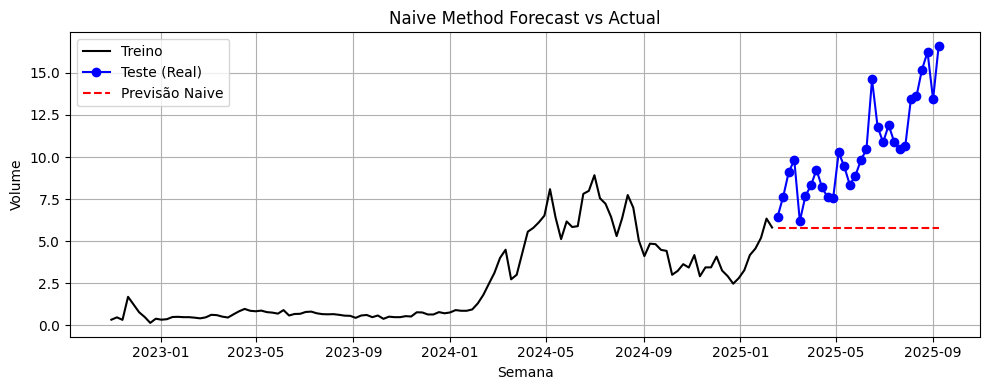

In [ ]:
# Naive forecast: predição = último valor do treino

# Calcular a previsão (o último valor do treino repetido para o tamanho do teste)
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))

# Avaliar o baseline Naive
naive_mae = mean_absolute_error(test_s, naive_pred)
naive_rmse = rmse(test_s, naive_pred)
naive_mape = mape(test_s, naive_pred)

# Armazenar os resultados
base_eval.append({'model': 'Naive', 'MAE': naive_mae, 'RMSE': naive_rmse, 'MAPE': naive_mape})

# Exibir os resultados para este baseline
print('Naive Method Results:')
print(f'  MAE: {naive_mae:.4f}')
print(f'  RMSE: {naive_rmse:.4f}')
print(f'  MAPE: {naive_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, naive_pred, label='Previsão Naive', color='red', linestyle='--')
plt.title('Naive Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método Sazonal Ingênuo (Seasonal Naive)

Este método é uma variação do método ingênuo, especialmente útil para séries com forte sazonalidade conhecida. Ele prevê o valor para um período futuro usando o valor observado no mesmo período sazonal do ciclo anterior.

A previsão para o período $T+h$ é dada por:

$\hat{y}_{T+h|T} = y_{T+h-m}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_{T+h-m}$ é o valor observado no mesmo período sazonal ($m$) do ciclo anterior mais recente disponível nos dados históricos.
- $m$ é o período da sazonalidade (por exemplo, $m=12$ para dados mensais com sazonalidade anual, $m=52$ para dados semanais com sazonalidade anual).

Este baseline é um forte concorrente para séries com padrões sazonais consistentes. Se um modelo não superar o Seasonal Naive para uma série sazonal, ele pode não estar capturando bem o componente sazonal.

Seasonal Naive Method Results:
  MAE: 4.7593
  RMSE: 5.4027
  MAPE: 44.0100%


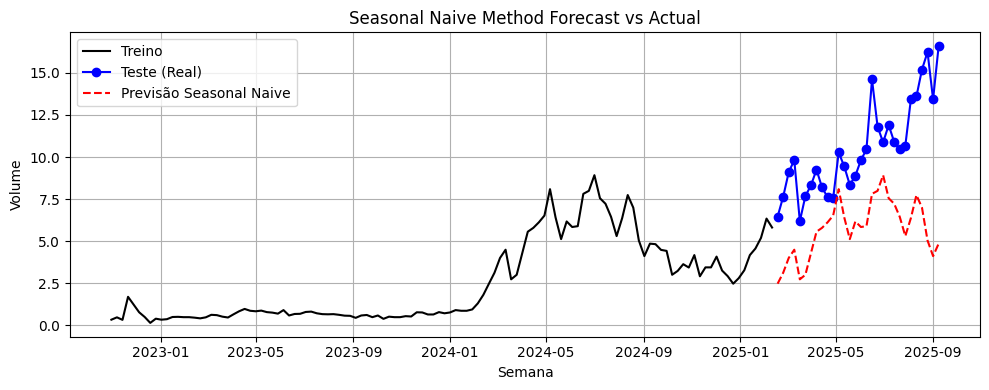

In [ ]:
# Seasonal Naive: predição = valor de t-period

# Calcular a previsão sazonal ingênua
seasonal_naive_pred = []
if len(train_s) >= SEASONAL_PERIOD:
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do último ano
        try:
            seasonal_naive_pred.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posição -period relativa ao fim do treino
            # Isso só aconteceria se o período de teste fosse muito grande
            # e extrapolasse os dados de treino disponíveis para o ciclo sazonal anterior.
            # Para test_size < SEASONAL_PERIOD, o try deve funcionar.
            print(f"Warning: Fallback used for index {idx}")
            seasonal_naive_pred.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive_pred) % SEASONAL_PERIOD)])
    seasonal_naive_pred = np.array(seasonal_naive_pred)

    # Avaliar o baseline Seasonal Naive
    seasonal_naive_mae = mean_absolute_error(test_s, seasonal_naive_pred)
    seasonal_naive_rmse = rmse(test_s, seasonal_naive_pred)
    seasonal_naive_mape = mape(test_s, seasonal_naive_pred)

    # Armazenar os resultados
    base_eval.append({'model': 'SeasonalNaive', 'MAE': seasonal_naive_mae, 'RMSE': seasonal_naive_rmse, 'MAPE': seasonal_naive_mape})

    # Exibir os resultados para este baseline
    print('Seasonal Naive Method Results:')
    print(f'  MAE: {seasonal_naive_mae:.4f}')
    print(f'  RMSE: {seasonal_naive_rmse:.4f}')
    print(f'  MAPE: {seasonal_naive_mape:.4f}%')

    plt.figure(figsize=(10, 4))
    plt.plot(train_s.index, train_s, label='Treino', color='black')
    plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
    # Usar o índice do teste para a previsão sazonal, garantindo alinhamento temporal
    plt.plot(test_s.index, seasonal_naive_pred, label='Previsão Seasonal Naive', color='red', linestyle='--')
    plt.title('Seasonal Naive Method Forecast vs Actual')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print(f"Não é possível calcular o Seasonal Naive. Tamanho do treino ({len(train_s)}) é menor que o período sazonal ({SEASONAL_PERIOD}).")

Método do Desvio (Drift Method)
O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao
longo do tempo. Este método assume que a diferença entre observações consecutivas é
constante, resultando em uma previsão que extrapola essa tendência:
yt = C + yt−1 + εt
A previsão para h períodos à frente é dada por:
^yT +h|T = yT + h ⋅ C
Onde C representa o desvio médio entre as observações:
C = ∑T
t=2(yt − yt−1)
T − 1 = yT − y1
T − 1
Portanto, a previsão pode ser reescrita como:
^yT +h|T = yT + h ( yT − y1
T − 1 )
Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo,
como crescimento linear.

### Método do Desvio (Drift Method)

O método do desvio é utilizado para séries temporais que seguem uma tendência linear ao longo do tempo. Este método assume que a diferença média entre observações consecutivas é constante, resultando em uma previsão que extrapola essa tendência:

$y_t = C + y_{t−1} + \epsilon_t$

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = y_T + h \cdot C$

Onde $C$ representa o desvio médio entre as observações no período de treino:

$C = \frac{\sum_{t=2}^T (y_t − y_{t−1})}{T − 1} = \frac{y_T − y_1}{T − 1}$

Portanto, a previsão pode ser reescrita como:

$\hat{y}_{T+h|T} = y_T + h \left( \frac{y_T − y_1}{T − 1} \right)$

Este método é útil para séries que apresentam uma tendência consistente ao longo do tempo, como crescimento linear. Ele é mais robusto que o Método Ingênuo para séries com tendência, pois incorpora essa inclinação média na previsão.

Drift Method Results:
  MAE: 3.9666
  RMSE: 4.6585
  MAPE: 34.3968%


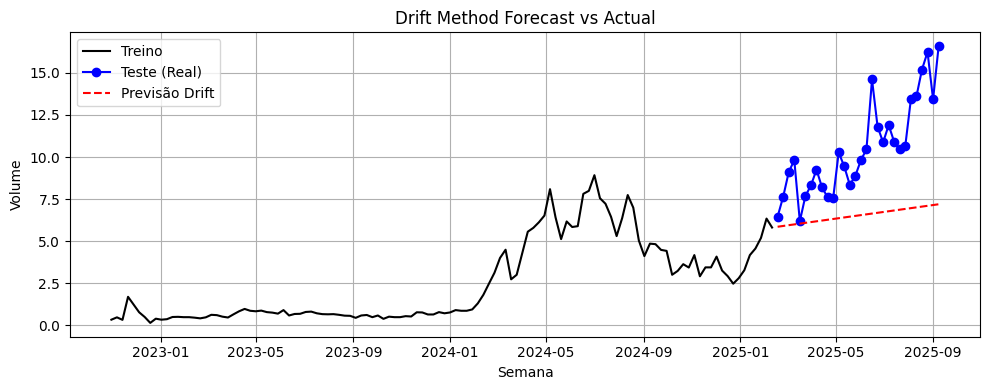

In [ ]:
# Drift Method: predição = último valor + h * desvio médio

# Calcular o desvio médio no conjunto de treino
# Desvio = (último valor do treino - primeiro valor do treino) / (Tamanho do treino - 1)
if len(train_s) > 1:
    drift = (train_s.iloc[-1] - train_s.iloc[0]) / (len(train_s) - 1)
else:
    # Se o treino tem apenas 1 ponto, o desvio é 0
    drift = 0
    print("Warning: Cannot calculate drift with only one training point. Drift set to 0.")


# Calcular a previsão para cada passo no conjunto de teste
# Previsão para h passos à frente = último valor do treino + h * drift
drift_pred = []
last_train_value = train_s.iloc[-1]
for h in range(1, len(test_s) + 1):
    drift_pred.append(last_train_value + h * drift)
drift_pred = np.array(drift_pred)


# Avaliar o baseline Drift Method
drift_mae = mean_absolute_error(test_s, drift_pred)
drift_rmse = rmse(test_s, drift_pred)
drift_mape = mape(test_s, drift_pred)

# Armazenar os resultados
base_eval.append({'model': 'Drift', 'MAE': drift_mae, 'RMSE': drift_rmse, 'MAPE': drift_mape})

# Exibir os resultados para este baseline
print('Drift Method Results:')
print(f'  MAE: {drift_mae:.4f}')
print(f'  RMSE: {drift_rmse:.4f}')
print(f'  MAPE: {drift_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
# Usar o índice do teste para a previsão Drift, garantindo alinhamento temporal
plt.plot(test_s.index, drift_pred, label='Previsão Drift', color='red', linestyle='--')
plt.title('Drift Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Método da Média Móvel (Rolling Mean)

O método da média móvel utiliza a média dos últimos $K$ valores observados como previsão para o futuro. Ele suaviza as flutuações de curto prazo e pode capturar tendências locais, mas não lida bem com sazonalidade forte ou tendências de longo prazo.

A previsão para $h$ períodos à frente é dada por:

$\hat{y}_{T+h|T} = \frac{y_{T} + y_{T-1} + ... + y_{T-K+1}}{K}$

Onde:
- $\hat{y}_{T+h|T}$ é a previsão para o período $T+h$, feita no tempo $T$.
- $y_i$ são os valores observados.
- $K$ é o número de períodos usados para calcular a média móvel.

Este baseline é mais reativo a mudanças recentes na série do que o Método da Média simples. O parâmetro $K$ pode ser ajustado; um $K$ menor torna a previsão mais responsiva a mudanças recentes, enquanto um $K$ maior a torna mais suave.

Rolling Mean (k=4) Method Results:
  MAE: 5.0153
  RMSE: 5.7318
  MAPE: 44.2030%


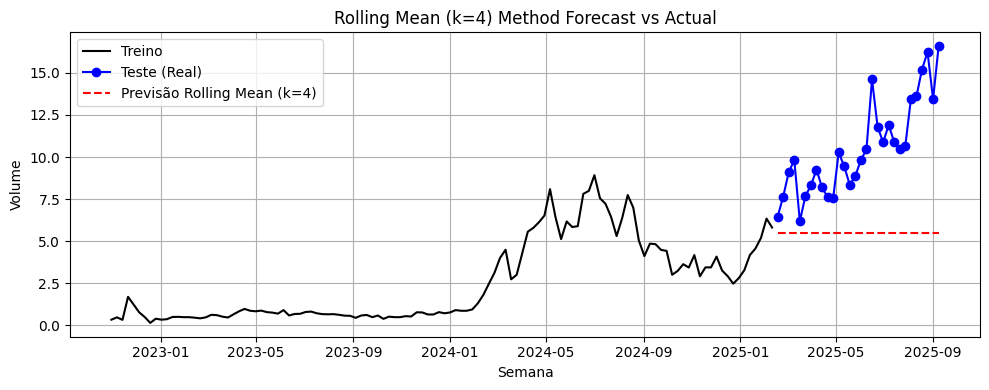

In [ ]:
# Rolling mean (últimos k)

# Calcular a previsão (média dos últimos K valores do treino repetida para o tamanho do teste)
# K é definido na célula de pré-configuração.
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))

# Avaliar o baseline Rolling Mean
rolling_mean_mae = mean_absolute_error(test_s, rolling_mean_pred)
rolling_mean_rmse = rmse(test_s, rolling_mean_pred)
rolling_mean_mape = mape(test_s, rolling_mean_pred)

# Armazenar os resultados
base_eval.append({'model': f'RollingMean_k{K}', 'MAE': rolling_mean_mae, 'RMSE': rolling_mean_rmse, 'MAPE': rolling_mean_mape})

# Exibir os resultados para este baseline
print(f'Rolling Mean (k={K}) Method Results:')
print(f'  MAE: {rolling_mean_mae:.4f}')
print(f'  RMSE: {rolling_mean_rmse:.4f}')
print(f'  MAPE: {rolling_mean_mape:.4f}%')

plt.figure(figsize=(10, 4))
plt.plot(train_s.index, train_s, label='Treino', color='black')
plt.plot(test_s.index, test_s, label='Teste (Real)', color='blue', marker='o')
plt.plot(test_s.index, rolling_mean_pred, label=f'Previsão Rolling Mean (k={K})', color='red', linestyle='--')
plt.title(f'Rolling Mean (k={K}) Method Forecast vs Actual')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Comparativo final de todos os baselines

# Converter a lista de resultados em um DataFrame pandas
base_eval_df = pd.DataFrame(base_eval)

base_eval_df_sorted = base_eval_df.sort_values(by='RMSE').reset_index(drop=True)

print('\nComparativo de Modelos Baseline:')
display(base_eval_df_sorted)


Comparativo de Modelos Baseline:


,model,MAE,RMSE,MAPE
0,Drift,3.966552,4.658450,34.396808
1,SeasonalNaive,4.759333,5.402674,44.010046
2,Naive,4.680333,5.441076,40.788894
3,RollingMean_k4,5.015333,5.731784,44.202960
4,Mean,7.963917,8.433490,74.252681


In [37]:
# Reorganizar o código dos Baselines

# Baselines
results = []

# 1) Mean Method: predição = média de todo o treino
# Este baseline simples usa a média histórica de todo o conjunto de treino como previsão constante.
mean_pred = np.repeat(train_s.mean(), len(test_s))
results.append(('Mean', mean_pred))


# 2) Naive forecast: predição = último valor do treino
# Este baseline simplesmente usa o último valor observado no conjunto de treino como previsão para todo o conjunto de teste.
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))
results.append(('Naive', naive_pred))

# 3) Seasonal Naive: se sazonalidade conhecida (period=52), predição = valor de t-period
# Este baseline é útil para séries com forte sazonalidade. Ele prevê o valor para um período futuro
# usando o valor observado no mesmo período sazonal (ex: mesma semana do ano) no último ciclo sazonal completo disponível no treino.
if len(train_s) >= SEASONAL_PERIOD:
    seasonal_naive = []
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do último ano
        try:
            seasonal_naive.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posição -period relativa ao fim do treino
            seasonal_naive.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive) % SEASONAL_PERIOD)])
    seasonal_naive = np.array(seasonal_naive)
    results.append(('SeasonalNaive', seasonal_naive))

# 4) Rolling mean (últimos k)
# Este baseline usa a média dos últimos K valores observados no conjunto de treino como previsão.
# É um suavizador simples e pode ser útil para séries com menos sazonalidade e mais ruído.
K = 4 # número de períodos para calcular a média móvel
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))
results.append((f'RollingMean_k{K}', rolling_mean_pred))

# avaliar baselines
base_eval = []
for name, pred in results:
    # Calcula as métricas de erro para cada baseline comparando a previsão com os valores reais do teste.
    mae = mean_absolute_error(test_s, pred)
    r = rmse(test_s, pred) # Usando a função rmse definida anteriormente
    m = mape(test_s, pred) # Usando a função mape definida anteriormente
    base_eval.append({'model': name, 'MAE': mae, 'RMSE': r, 'MAPE': m})

base_eval_df = pd.DataFrame(base_eval)
print('\nBaseline results:')
print(base_eval_df)


Baseline results:
            model       MAE      RMSE       MAPE
0            Mean  7.963917  8.433490  74.252681
1           Naive  4.680333  5.441076  40.788894
2   SeasonalNaive  4.759333  5.402674  44.010046
3  RollingMean_k4  5.015333  5.731784  44.202960


In [20]:
# Baselines
results = []

# 1) Naive forecast: predição = último valor do treino
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))
results.append(('Naive', naive_pred))

# 2) Seasonal Naive: se sazonalidade conhecida (period=52), predição = valor de t-period
if len(train_s) >= SEASONAL_PERIOD:
    seasonal_naive = []
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do último ano
        try:
            seasonal_naive.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posição -period relativa ao fim do treino
            seasonal_naive.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive) % SEASONAL_PERIOD)])
    seasonal_naive = np.array(seasonal_naive)
    results.append(('SeasonalNaive', seasonal_naive))

# 3) Rolling mean (últimos k)
K = 4
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))
results.append((f'RollingMean_k{K}', rolling_mean_pred))

# avaliar baselines
base_eval = []
for name, pred in results:
    mae = mean_absolute_error(test_s, pred)
    r = rmse(test_s, pred)
    m = mape(test_s, pred)
    base_eval.append({'model': name, 'MAE': mae, 'RMSE': r, 'MAPE': m})

base_eval_df = pd.DataFrame(base_eval)
print('\nBaseline results:')
print(base_eval_df)



Baseline results:
            model       MAE      RMSE       MAPE
0           Naive  4.680333  5.441076  40.788894
1   SeasonalNaive  4.759333  5.402674  44.010046
2  RollingMean_k4  5.015333  5.731784  44.202960


# Regressão Linear Múltipla

In [21]:
# Regressão linear múltipla com features temporais

X = pd.DataFrame(index=train_s.index)
X['t'] = np.arange(len(train_s))
X['sin52'] = np.sin(2 * np.pi * X['t'] / SEASONAL_PERIOD)
X['cos52'] = np.cos(2 * np.pi * X['t'] / SEASONAL_PERIOD)

if isinstance(train_s.index, pd.DatetimeIndex):
    # Semana do ano
    X['weekofyear'] = train_s.index.isocalendar().week.astype(int).values
    # Dummies de mês
    month_dummies = pd.get_dummies(train_s.index.month, prefix='m', drop_first=True)
    month_dummies.index = train_s.index  # alinhando índices
    X = pd.concat([X, month_dummies], axis=1)


# Ajustar regressão
lr = LinearRegression()
lr.fit(X, train_s.values)

print('\nCoeficientes da regressão multivariada:')
for name, coef in zip(X.columns, lr.coef_):
    print(f"{name}: {coef:.4f}")


# Construir features para teste
X_test = pd.DataFrame(index=test_s.index)
X_test['t'] = np.arange(len(train_s), len(train_s) + len(test_s))
X_test['sin52'] = np.sin(2 * np.pi * X_test['t'] / SEASONAL_PERIOD)
X_test['cos52'] = np.cos(2 * np.pi * X_test['t'] / SEASONAL_PERIOD)

if isinstance(train_s.index, pd.DatetimeIndex):
    X_test['weekofyear'] = test_s.index.isocalendar().week.astype(int).values
    month_dummies_test = pd.get_dummies(test_s.index.month, prefix='m', drop_first=True)
    month_dummies_test.index = test_s.index
    X_test = pd.concat([X_test, month_dummies_test], axis=1)

# Alinhar colunas
for c in X.columns:
    if c not in X_test.columns:
        X_test[c] = 0
X_test = X_test[X.columns]

# Previsão e avaliação
reg_pred = lr.predict(X_test)

lr_mae = mean_absolute_error(test_s, reg_pred)
lr_rmse = rmse(test_s, reg_pred)
lr_mape = mape(test_s, reg_pred)

print(f"\nRegressão linear: MAE={lr_mae:.3f}, RMSE={lr_rmse:.3f}, MAPE={lr_mape:.2f}%")

# Armazenar resultados
model_eval = []
model_eval.append({'model': 'LinearRegression', 'MAE': lr_mae, 'RMSE': lr_rmse, 'MAPE': lr_mape})



Coeficientes da regressão multivariada:
t: 0.0536
sin52: -0.2633
cos52: -0.7769
weekofyear: 0.0303
m_2: 0.2010
m_3: 0.0706
m_4: 0.7038
m_5: 0.2950
m_6: 0.3551
m_7: 0.3814
m_8: 0.0828
m_9: -0.8424
m_10: -1.3475
m_11: -0.6617
m_12: -1.3444

Regressão linear: MAE=3.161, RMSE=4.055, MAPE=26.44%


In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Funções auxiliares ---
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def sarima_optimized_search(train, s=52):
    """
    Busca SARIMA otimizada: testa apenas combinações plausíveis de (p,d,q)x(P,D,Q,s)
    e retorna o modelo com menor AIC.
    """
    # Combinações mais comuns para séries semanais
    pdq = [(0,1,1), (1,1,0), (1,1,1), (0,1,0)]
    seasonal_pdq = [(0,1,1), (1,1,0), (1,1,1), (0,1,0)]

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    for order in pdq:
        for seasonal in seasonal_pdq:
            seasonal_order = (*seasonal, s)
            try:
                model = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = results
            except Exception:
                continue

    return best_model, best_order, best_seasonal_order, best_aic

# --- Exemplo de dados ---
data = pd.Series(
    [100, 105, 102, 108, 110, 115, 120, 125, 123, 130, 128, 135],
    index=pd.date_range(start='2025-01-01', periods=12, freq='W')
)

train_s = data[:8]  # treino
test_s = data[8:]   # teste

# --- Inicializar lista de resultados ---
model_eval = []

# --- Busca SARIMA otimizada ---
s = 52  # sazonalidade semanal
best_model, best_order, best_seasonal_order, best_aic = sarima_optimized_search(train_s.values, s=s)

print(f"Melhor modelo SARIMA: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

# --- Previsão ---
arima_pred = best_model.forecast(steps=len(test_s))

# --- Avaliação ---
arima_mae = mean_absolute_error(test_s, arima_pred)
arima_rmse = rmse(test_s.values, arima_pred)
arima_mape = mape(test_s.values, arima_pred)

print(f"\nSARIMA: MAE={arima_mae:.3f}, RMSE={arima_rmse:.3f}, MAPE={arima_mape:.2f}%")

# --- Armazenar resultados ---
model_eval.append({
    'model': 'SARIMA',
    'MAE': arima_mae,
    'RMSE': arima_rmse,
    'MAPE': arima_mape
})

print("\nResultados armazenados:", model_eval)

Melhor modelo SARIMA: order=(0, 1, 0), seasonal_order=(0, 1, 0, 52), AIC=2.00

SARIMA: MAE=5.000, RMSE=5.874, MAPE=3.81%

Resultados armazenados: [{'model': 'SARIMA', 'MAE': 5.0, 'RMSE': np.float64(5.873670062235365), 'MAPE': np.float64(3.805831878430964)}]


In [ ]:
# Diagnóstico de resíduos para o melhor modelo (exemplo: SARIMAX/resíduos de regressão)
# escolher resíduos do modelo SARIMA se existir, senão da regressão
residuals = None
if arima_pred is not None:
    residuals = test_s.values - arima_pred
    res_name = 'ARIMA_resid'
else:
    residuals = test_s.values - reg_pred
    res_name = 'LR_resid'

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(residuals)
plt.title(f'Resíduos - {res_name}')
plt.subplot(1,2,2)
plt.hist(residuals, bins=20)
plt.title('Histograma dos resíduos')
plt.tight_layout()
plt.show()

# ACF/PACF
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.subplot(1,2,2)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

# Ljung-Box
lb = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print('\nLjung-Box test (resíduos):')
print(lb)

In [ ]:
# Comparação final de modelos (baselines + regression + arima if available)
# compilar resultados
if 'base_eval_df' in globals():
    comp = base_eval_df.copy()
else:
    comp = pd.DataFrame()

comp = comp.append(pd.DataFrame(model_eval), ignore_index=True, sort=False).fillna('-')
print('\nComparação de modelos:')
print(comp.sort_values('RMSE'))

# ---------------------
# Salvar previsões e resultados
# ---------------------
out_dir = Path('results')
out_dir.mkdir(exist_ok=True)

# salvar previsões dos modelos testados
predictions = pd.DataFrame(index=test_s.index)
predictions['actual'] = test_s.values
# baselines
for name, pred in results:
    predictions[name] = pred
# regression
predictions['LinearRegression'] = reg_pred
# arima
if arima_pred is not None:
    predictions['ARIMA'] = arima_pred

predictions.to_csv(out_dir / 'predictions.csv')
comp.to_csv(out_dir / 'model_comparison.csv', index=False)

print(f"\nArquivos salvos em: {out_dir.resolve()}\n - predictions.csv\n - model_comparison.csv")

## Regressão linear múltipla

# Resumo dos Modelos de Regressão

Análise completa de séries temporais, incluindo regressão linear múltipla e modelos SARIMAX, com diagnóstico de resíduos e comparação de desempenho.

---

## 1. Regressão Linear Múltipla (OLS)

### Estrutura do modelo
- **Variável dependente:** `volume` (série temporal)
- **Preditores utilizados:**
  - `t` → tendência linear ao longo do tempo
  - Harmônicos sazonais:
    - `sin1`, `cos1` → 1º harmônico (captura sazonalidade básica)
    - `sin2`, `cos2` → 2º harmônico (captura sazonalidade mais complexa)
  - Dummies de mês (`m_2`, ..., `m_12`) → capturam efeito fixo mensal
- **Intercepto** adicionado automaticamente pelo `sm.add_constant()`

### Objetivo
- Ajustar um modelo de regressão que capture **tendência + sazonalidade** de forma interpretável.

### Diagnóstico de resíduos
- **ACF/PACF:** Verifica autocorrelação nos resíduos → idealmente devem ser ruído branco.
- **Histograma:** Avalia normalidade aproximada.
- **QQ-Plot:** Comparação com distribuição normal.
- **Teste de Ljung-Box:** Detecta autocorrelação residual significativa.
- **Resultados:** Resíduos podem indicar necessidade de incluir lags ou migrar para SARIMAX.

### Treino/Teste
- Conjunto de treino: 80% inicial da série.
- Conjunto de teste: últimas 12 semanas (`TEST_SIZE`).
- Métricas de performance no teste:
  - **RMSE**
  - **MAPE**
- Previsões geradas tanto para treino quanto para teste.

---

## 2. Modelos SARIMAX

### Estrutura
- Modelos ARIMA/SARIMA para capturar:
  - Autoregressão (AR)
  - Diferença (I)
  - Média móvel (MA)
  - Sazonalidade (P,D,Q,m)
- Ajuste via:
  - `pmdarima.auto_arima()` se disponível (automático)
  - Grid search conservador manual com `statsmodels.SARIMAX`

### Objetivo
- Capturar dependências temporais que OLS não consegue modelar, incluindo sazonalidade e autocorrelação nos resíduos.

### Diagnóstico de resíduos
- Mesmos gráficos do OLS:
  - ACF/PACF
  - Histograma
  - QQ-Plot
  - Ljung-Box
- Permite avaliar qualidade do ajuste SARIMAX.

### Forecasting
- Previsão das últimas 12 semanas.
- Métricas de performance:
  - **RMSE**
  - **MAPE**
- Comparação direta com o modelo de regressão.

---

## 3. Comparação de Modelos

| Modelo                                      | AIC   | BIC   | RMSE  | MAPE  |
|--------------------------------------------|-------|-------|-------|-------|
| Regressão (tendência + harmônicos + mês)   | -     | -     | X.XXXX| X.XXXX|
| Melhor SARIMAX                              | XX.XX | XX.XX | X.XXXX| X.XXXX|

> **Observações:**
> - AIC/BIC só são computados para modelos SARIMAX.
> - OLS é avaliado por RMSE/MAPE no conjunto de teste.

---

## 4. Saída do Script

- **Relatórios e plots gerados:**
  - `ols_summary.txt` → resumo do modelo OLS
  - `ols_resid_acf.png`, `ols_resid_pacf.png`, `ols_resid_hist.png`, `ols_resid_qq.png`
  - `ols_ljungbox.csv` → teste de Ljung-Box
  - `sarimax_summaries.txt` → top SARIMAX models
  - `sarimax_resid_*` → gráficos de diagnóstico SARIMAX
  - `sarimax_ljungbox.csv`
  - `model_predictions_comparison.csv` → comparação de previsões OLS vs SARIMAX
  - `model_comparison.csv` → métricas finais
  - `readme_results.txt` → resumo legível dos resultados

---

**Conclusão:**
- O script combina **modelos de regressão interpretáveis** (tendência + harmônicos + dummies) com **modelos SARIMAX robustos** para capturar dependência temporal e sazonalidade.  
- Permite **diagnóstico completo** e **comparação de performance**, salvando todas as informações para análise posterior.


In [ ]:
"""
Análise completa de séries temporais com:
 - Regressão linear múltipla (tendência + harmônicos sazonais + dummies de mês)
 - Modelos ARIMA/SARIMA (statsmodels; opcional: pmdarima.auto_arima)
 - Resultados para diagnóstico de resíduos (ACF/PACF, Ljung-Box, histograma, QQplot)
 - Comparação por AIC/BIC/RMSE/MAPE
 - Exportação de resultados e plots

Salva resultados em ./results_linear_regression/
"""

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# -------------------------
# Configurações gerais
# -------------------------
OUTDIR = Path("./results_linear_regression")
OUTDIR.mkdir(parents=True, exist_ok=True)

data_csv = "data.csv"
# data_csv = """week,volume
#               2022-10-31,0.33
#               ...
#            """

INPUT_CSV_PATH = Path("data.csv")  # usado se data_csv for None

# Parâmetros de modelagem
SEASONAL_PERIOD = 52        # sazonalidade anual em semanas (~52, uma ano)
TEST_SIZE = 12              # número de semanas no conjunto de teste para validação
SARIMAX_GRID_SMALL = {
    "p": [0, 1, 2],
    "d": [0, 1],
    "q": [0, 1],
    "P": [0, 1],
    "D": [0, 1],
    "Q": [0, 1],
}


In [ ]:
# -------------------------
# Funções utilitárias
# -------------------------
INPUT_CSV_PATH = "data.csv"  # caminho do arquivo local

def load_data():
    """Carrega os dados do CSV (arquivo) e prepara a série temporal."""
    df = pd.read_csv(INPUT_CSV_PATH, parse_dates=["week"])
    df = df.sort_values("week").reset_index(drop=True)
    df = df.set_index("week")
    df.index = pd.to_datetime(df.index)

    # Garantir numérico
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

    # Interpolar eventuais gaps (caso haja)
    df["volume"] = df["volume"].interpolate()

    return df



def evaluate(y_true, y_pred, model=None):
    """Calcula métricas de avaliação."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results = {"rmse": float(rmse), "mape": float(mape), "r2": float(r2)}

    if model is not None:
        results["r2_adj"] = float(model.rsquared_adj)
        results["std_err_reg"] = float(model.mse_resid ** 0.5)

    return results



In [ ]:
# -------------------------
# Carregamento e features
# -------------------------
df = load_data()
df.to_csv(OUTDIR / "data_used.csv") # ordena por data, interpola se tiver valores faltantes.

data = df.reset_index()
T = len(data)
data["t"] = np.arange(1, T + 1)  # tendência (linear) , que cresce de 1 até T, para capturar crescimento/queda ao longo do tempo.

# Harmônicos para sazonalidade (1º e 2º harmônicos)
data["sin1"] = np.sin(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos1"] = np.cos(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["sin2"] = np.sin(4 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos2"] = np.cos(4 * np.pi * data["t"] / SEASONAL_PERIOD)

# Dummies para mês (poderia ser semana do ano, dia da semana, etc.)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True)
data = pd.concat([data, month_dummies], axis=1)
# print(data)

# Preditores para regressão
predictors = ["t", "sin1", "cos1", "sin2", "cos2"] + list(month_dummies.columns) # variáveis explicativas.
X_all = sm.add_constant(data[predictors]) # adiciona a constante (intercepto) ao modelo.
y_all = data["volume"] # variável resposta (a série volume).


# Criar preditores
t = np.arange(len(data))
X_all = pd.DataFrame({"t": t})
for k in range(1, 3):
    X_all[f"sin{k}"] = np.sin(2*np.pi*k*t/SEASONAL_PERIOD)
    X_all[f"cos{k}"] = np.cos(2*np.pi*k*t/SEASONAL_PERIOD)

# Dummies de mês (converter direto para float)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True).astype(float)

X_all = pd.concat([X_all, month_dummies], axis=1)
X_all = sm.add_constant(X_all).astype(float)

y_all = data["volume"].astype(float)


In [ ]:
# -------------------------
# Regressão OLS (full sample)
# -------------------------

#Ajuste do modelo OLS (Mínimos Quadrados Ordinários)
ols_full = sm.OLS(y_all, X_all).fit() #estima os coeficientes que minimizam a soma dos erros quadrados.
(OUTDIR / "ols_summary.txt").write_text(ols_full.summary().as_text()) # gera estatísticas do modelo (coeficientes, R², p-values, etc.)

# Residual diagnostics (OLS)

#vetor de resíduos. São usados para avaliar se o modelo capturou bem a estrutura da série.
resid = ols_full.resid

# ACF (Autocorrelation Function): mede se os resíduos estão correlacionados ao longo do tempo.
# Idealmente, resíduos devem ser ruído branco → sem autocorrelação significativa.
# Se houver autocorrelação, significa que o modelo não capturou toda a dependência temporal.
fig = plt.figure(figsize=(8,4))
plot_acf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_acf.png")
plt.show()
plt.close(fig)

# PACF (Partial Autocorrelation Function): mostra a autocorrelação de uma defasagem, condicionada às defasagens anteriores.
# Ajuda a detectar se ainda existe estrutura AR (autoregressiva) nos resíduos.
fig = plt.figure(figsize=(8,4))
plot_pacf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_pacf.png")
plt.show()
plt.close(fig)

# Histograma dos resíduos
# Verifica se os resíduos seguem uma distribuição aproximadamente normal (hipótese da regressão linear).
# Se houver caudas pesadas ou assimetria, pode indicar problemas no ajuste.
fig = plt.figure(figsize=(6,4))
plt.hist(resid, bins=25)
plt.title("Histograma dos resíduos (OLS)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "ols_resid_hist.png")
plt.show()
plt.close(fig)

# QQ-plot (Quantile-Quantile)
# Compara os quantis dos resíduos com os quantis de uma distribuição normal.
# Se os pontos seguirem a linha → resíduos são aproximadamente normais.
# Se houver desvios nas caudas → problemas de heterocedasticidade ou não-normalidade.
fig = qqplot(resid, line="s")
fig.suptitle("QQ-plot resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_qq.png")
plt.show()
plt.close(fig)

# Teste de Ljung-Box
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
lb.to_csv(OUTDIR / "ols_ljungbox.csv")


In [ ]:
# -------------------------
# Treino / Teste (para comparar previsões)
# -------------------------

train = data.iloc[:-TEST_SIZE].copy()
test = data.iloc[-TEST_SIZE:].copy()

y_train = train["volume"]
y_test = test["volume"]

X_train = sm.add_constant(train[predictors])
X_test = sm.add_constant(test[predictors])

y_train = pd.to_numeric(y_train, errors="coerce").astype(float)
y_test = pd.to_numeric(y_test, errors="coerce").astype(float)

X_train = X_train.apply(pd.to_numeric, errors="coerce").astype(float)
X_test = X_test.apply(pd.to_numeric, errors="coerce").astype(float)



ols_train = sm.OLS(y_train, X_train).fit()
reg_pred = ols_train.predict(X_test)
reg_metrics = evaluate(y_test, reg_pred)

pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_true": y_test.values,
    "reg_pred": reg_pred.values
})


In [ ]:
# -------------------------
# SARIMAX modeling
# - Tenta usar pmdarima.auto_arima se disponível (mais prático)
# - Se não, faz um grid search pequeno com statsmodels.SARIMAX
# -------------------------
use_auto = False
try:
    import pmdarima as pm
    use_auto = True
except Exception:
    use_auto = False

sarimax_results = []
if use_auto:
    # auto_arima (rápido se stepwise; precisa de pmdarima instalado)
    auto = pm.auto_arima(y_train, seasonal=True, m=SEASONAL_PERIOD,
                         stepwise=True, suppress_warnings=True, error_action="ignore")
    order = auto.order
    seasonal_order = auto.seasonal_order
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    sarimax_results.append({"model": f"AUTO ({order}) x {seasonal_order}", "aic": res.aic, "bic": res.bic, "res": res})
else:
    # Grid search conservador (ajuste os ranges em SARIMAX_GRID_SMALL para explorar mais)
    p_range = SARIMAX_GRID_SMALL["p"]
    d_range = SARIMAX_GRID_SMALL["d"]
    q_range = SARIMAX_GRID_SMALL["q"]
    P_range = SARIMAX_GRID_SMALL["P"]
    D_range = SARIMAX_GRID_SMALL["D"]
    Q_range = SARIMAX_GRID_SMALL["Q"]
    m = SEASONAL_PERIOD

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                mod = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                              enforce_stationarity=False, enforce_invertibility=False)
                                res = mod.fit(disp=False, low_memory=True)
                                sarimax_results.append({
                                    "model": f"SARIMAX ({p},{d},{q}) x ({P},{D},{Q},{m})",
                                    "aic": res.aic, "bic": res.bic, "res": res
                                })
                            except Exception as e:
                                # falhas de convergência são normais em grid search; ignoramos
                                continue

# Se não houve modelos (por falha), interrompa
if len(sarimax_results) == 0:
    raise RuntimeError("Não foi possível ajustar nenhum modelo SARIMAX. Tente ajustar ranges menores ou instalar pmdarima.")

# Ordena por AIC e guarda top models
sarimax_results = sorted(sarimax_results, key=lambda x: x["aic"])
top_results = sarimax_results[:5]
# salva summaries
summaries_txt = ""
for i, item in enumerate(top_results):
    summaries_txt += f"Model {i+1}: {item['model']}  AIC={item['aic']:.2f}  BIC={item['bic']:.2f}\n"
    summaries_txt += item["res"].summary().as_text()
    summaries_txt += "\n\n" + ("-"*80) + "\n\n"
(OUTDIR / "sarimax_summaries.txt").write_text(summaries_txt)

# Escolhe o melhor para previsões (top_results[0])
best_res = top_results[0]["res"]

# Forecasting (estático/determinístico): preve as próximas TEST_SIZE semanas
sarimax_forecast_obj = best_res.get_forecast(steps=TEST_SIZE)
sarimax_pred_mean = sarimax_forecast_obj.predicted_mean
# Alinha índices com as semanas reais do conjunto de teste
sarimax_pred_mean.index = test["week"].values

sarimax_metrics = evaluate(y_test, sarimax_pred_mean)

pred_df["sarimax_pred"] = sarimax_pred_mean.values
pred_df.to_csv(OUTDIR / "model_predictions_comparison.csv", index=False)


In [ ]:

# Residual diagnostics (melhor SARIMAX)
resid_s = best_res.resid
fig = plt.figure(figsize=(8,4))
plot_acf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_acf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,4))
plot_pacf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_pacf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(6,4))
plt.hist(resid_s, bins=25)
plt.title("Histograma resíduos (SARIMAX)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "sarimax_resid_hist.png")
plt.show()
plt.close(fig)

fig = qqplot(resid_s, line="s")
fig.suptitle("QQ-plot resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_qq.png")
plt.show()
plt.close(fig)

lb_s = acorr_ljungbox(resid_s, lags=[10, 20], return_df=True)
lb_s.to_csv(OUTDIR / "sarimax_ljungbox.csv")




In [ ]:
# -------------------------
# Comparação final e salvamento
# -------------------------
comparison = pd.DataFrame([
    {
        "model": "Regression (trend+harmonics+month dummies)",
        "aic": np.nan, "bic": np.nan,
        "rmse": reg_metrics["rmse"], "mape": reg_metrics["mape"]
    },
    {
        "model": top_results[0]["model"],
        "aic": top_results[0]["aic"], "bic": top_results[0]["bic"],
        "rmse": sarimax_metrics["rmse"], "mape": sarimax_metrics["mape"]
    }
])
comparison.to_csv(OUTDIR / "model_comparison.csv", index=False)

# Save a short human-readable summary
summary = f"""
Análise completa salva em: {OUTDIR.resolve()}
Regressão (teste último {TEST_SIZE}): RMSE={reg_metrics['rmse']:.4f}, MAPE={reg_metrics['mape']:.4f}
SARIMAX (teste último {TEST_SIZE}): RMSE={sarimax_metrics['rmse']:.4f}, MAPE={sarimax_metrics['mape']:.4f}
Melhor SARIMAX: {top_results[0]['model']} (AIC={top_results[0]['aic']:.2f}, BIC={top_results[0]['bic']:.2f})
"""
(OUTDIR / "readme_results.txt").write_text(summary)
print(summary)

# Lista arquivos gerados
print("Arquivos gerados:")
for p in sorted(OUTDIR.iterdir()):
    print("-", p.name)


In [ ]:
# garante que 'week' está em datetime
df_check["week"] = pd.to_datetime(df_check["week"])

plt.figure(figsize=(12,6))
plt.plot(df_check["week"], df_check["volume"], marker="o", linestyle="-", color="black")

plt.title("Série Temporal Original - Volume por Semana")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------
# Preparar previsões com IC
# -------------------------

# 1️ Previsão OLS
ols_forecast_obj = ols_train.get_prediction(X_test)
ols_pred_mean = ols_forecast_obj.predicted_mean
ols_ci = ols_forecast_obj.conf_int(alpha=0.05)

ols_pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_pred": ols_pred_mean,
    "ci_lower": ols_ci[:, 0],
    "ci_upper": ols_ci[:, 1]
})

# 2️ Previsão SARIMAX
sarimax_forecast_obj = best_res.get_forecast(steps=len(test))
sarimax_forecast_df = sarimax_forecast_obj.summary_frame(alpha=0.05)

# Garantir alinhamento correto com o eixo x
sarimax_pred_df = sarimax_forecast_df.copy()
sarimax_pred_df["week"] = test["week"].values
sarimax_pred_df.rename(columns={
    "mean": "y_pred",
    "mean_ci_lower": "ci_lower",
    "mean_ci_upper": "ci_upper"
}, inplace=True)

# -------------------------
# Plotagem
# -------------------------
plt.figure(figsize=(12,6))

# Treino
plt.plot(train["week"], train["volume"], color="black", linestyle="-", label="Treino")

# Teste (real)
plt.plot(test["week"], test["volume"], color="black", marker=".", linestyle="None", label="Teste (real)")

# OLS
plt.plot(ols_pred_df["week"], ols_pred_df["y_pred"], color="blue", linestyle="--", label="Previsão OLS")
plt.fill_between(ols_pred_df["week"], ols_pred_df["ci_lower"], ols_pred_df["ci_upper"],
                 color="blue", alpha=0.2, label="IC 95% OLS")

# SARIMAX
plt.plot(sarimax_pred_df["week"], sarimax_pred_df["y_pred"], color="red", linestyle="--", label="Previsão SARIMAX")
plt.fill_between(sarimax_pred_df["week"], sarimax_pred_df["ci_lower"], sarimax_pred_df["ci_upper"],
                 color="red", alpha=0.2, label="IC 95% SARIMAX")

# Estilo e labels
plt.title("Comparação de Previsões OLS e SARIMAX com Intervalos de Confiança")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvar e mostrar
plt.savefig(OUTDIR / "forecast_comparison.png")
plt.show()
plt.close()


# Análise de resíduos e ajuste dos modelos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro

# ============================================================
# 1. Carregar a série
# ============================================================
df = pd.read_csv("data.csv", parse_dates=["week"])
df.set_index("week", inplace=True)
serie = df["volume"]

# ============================================================
# 2. Ajustar um modelo ARIMA (exemplo)
# ============================================================
modelo = sm.tsa.ARIMA(serie, order=(1,1,1))  # pode ajustar os parâmetros
fit = modelo.fit()
residuos = fit.resid

# ============================================================
# 3. Visualização dos resíduos
# ============================================================
plt.figure(figsize=(12,4))
plt.plot(residuos, marker="o")
plt.title("Resíduos do Modelo")
plt.axhline(0, color="red", linestyle="--")
plt.show()

# ============================================================
# 4. Histograma + QQ-plot (normalidade)
# ============================================================
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(residuos, kde=True, ax=ax[0])
ax[0].set_title("Histograma dos resíduos")

sm.qqplot(residuos, line="s", ax=ax[1])
ax[1].set_title("QQ-plot dos resíduos")
plt.show()

# ============================================================
# 5. ACF/PACF dos resíduos
# ============================================================
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(residuos, ax=ax[0], lags=10)
plot_pacf(residuos, ax=ax[1], lags=10, method="ywm")
plt.show()

# ============================================================
# 6. Testes estatísticos
# ============================================================

print("Média dos resíduos:", np.mean(residuos))

# Shapiro-Wilk
stat, p = shapiro(residuos)
print(f"Shapiro-Wilk: stat={stat:.4f}, p={p:.4f}")

# Jarque-Bera
jb_stat, jb_p, _, _ = jarque_bera(residuos)
print(f"Jarque-Bera: stat={jb_stat:.4f}, p={jb_p:.4f}")

# Ljung-Box
lb = acorr_ljungbox(residuos, lags=[5,10], return_df=True)
print("\nTeste de Ljung-Box:")
print(lb)

# Breusch-Pagan
X = fit.fittedvalues.values.reshape(-1,1)
bp_test = het_breuschpagan(residuos, sm.add_constant(X))
labels = ["LM stat", "LM pval", "F stat", "F pval"]
print("\nBreusch-Pagan:")
print(dict(zip(labels, bp_test)))
